In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow_datasets as tfds

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

from rec.models.resnet_vae import BidirectionalResNetVAE
from rec.models.custom_modules import ReparameterizedConv2D, ReparameterizedConv2DTranspose, GDN
from rec.models.pixel_cnn import PixelCNNResidualBlock

from rec.coding.coder import GaussianCoder
from rec.coding.samplers import ImportanceSampler

from rec.core.utils import gaussian_blur

from rec.models.large_resnet_vae import LargeResNetVAE

from rec.io.entropy_coding import ArithmeticCoder

import glob

import struct

In [2]:
# Taken from https://github.com/tensorflow/tensorflow/issues/31135#issuecomment-516526113
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
dataset_path = "/scratch/gf332/datasets/clic2019/test"

files = glob.glob(f"{dataset_path}/*.png")

In [4]:
def read_png(filename):
    """
    Loads a PNG image file. Taken from Balle's implementation
    """
    image_raw = tf.io.read_file(filename)
    image = tf.image.decode_image(image_raw, channels=3)
    image = tf.cast(image, tf.float32)

    return image


In [6]:
im = read_png(files[0])

In [675]:
x = tf.ones((1, 256, 265, 3))
y = 0.2 * tf.random.uniform((1, 256, 265, 3))

tf.image.ssim_multiscale(x, y, max_val=1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5841908], dtype=float32)>

In [22]:
(512, 1264, 3)

(512, 1264, 3)

In [31]:
(1264 - (1264 % 64)) / 64

19.0

In [12]:
x = tf.random.uniform((1, 2, 3, 4), dtype=tf.float32)
y = GDN(inverse=False)(x)
print(x.shape, y.shape)
print(tf.reduce_max(tf.abs(y - x / tf.sqrt(1 + .1 * (x ** 2)))))

x = tf.random.uniform((1, 2, 3, 4), dtype=tf.float32)
y = GDN(inverse=True)(x)
print(x.shape, y.shape)
print(tf.reduce_max(tf.abs(y - x * tf.sqrt(1 + .1 * (x ** 2)))))

(1, 2, 3, 4) (1, 2, 3, 4)
tf.Tensor(2.3841858e-07, shape=(), dtype=float32)
(1, 2, 3, 4) (1, 2, 3, 4)
tf.Tensor(0.0, shape=(), dtype=float32)


In [33]:
!ls /scratch/gf332/models/relative-entropy-coding/clic2019/large_resnet_vae/beta_0.500_lamb_0.100_laplace_target_bpp_0.300/clic2019/reconstructions/thong-vo-428.png_block_indices.npy

relative-entropy-coding


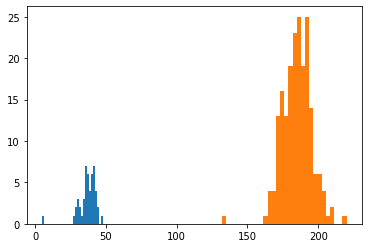

In [9]:
num_aux_vars = list(map(len, block_indices[0]))

plt.hist(num_aux_vars, bins=30)

num_aux_vars = list(map(len, block_indices[1]))

plt.hist(num_aux_vars, bins=30)
plt.show()

In [70]:
[1, 2, 3][2:10]

[3]

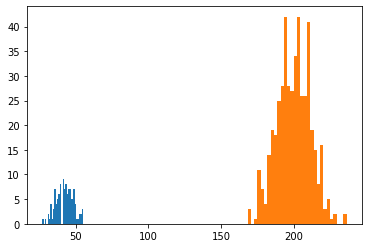

In [40]:
num_aux_vars = list(map(len, block_indices[0]))

plt.hist(num_aux_vars, bins=30)

num_aux_vars = list(map(len, block_indices[1]))

plt.hist(num_aux_vars, bins=30)
plt.show()

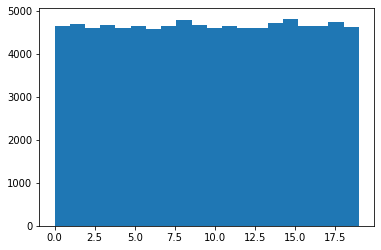

In [44]:
indices = np.concatenate(block_indices[1], axis=0)

plt.hist(indices, bins=20)
plt.show()

In [48]:
np.unique(indices)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32)

In [3]:
!ls ../../../models/relative-entropy-coding/imagenet32/resnet_vae/gaussian/blocks_24/beta_1.000_lamb_0.100/

checkpoint		       ckpt-2127.index
ckpt-2126.data-00000-of-00002  ckpt-2128.data-00000-of-00002
ckpt-2126.data-00001-of-00002  ckpt-2128.data-00001-of-00002
ckpt-2126.index		       ckpt-2128.index
ckpt-2127.data-00000-of-00002  logs
ckpt-2127.data-00001-of-00002


In [4]:
model_save_dir = "../../../models/relative-entropy-coding/imagenet32/resnet_vae/gaussian/blocks_24/beta_1.000_lamb_0.100/"

In [5]:
model = BidirectionalResNetVAE(use_iaf=False,
                               num_res_blocks=24,
                               deterministic_filters=160,
                               stochastic_filters=32)

model(tf.zeros((1, 32, 32, 3)))

# -------------------------------------------------------------------------
# Create Checkpoints
# -------------------------------------------------------------------------
ckpt = tf.train.Checkpoint(model=model)

manager = tf.train.CheckpointManager(ckpt, model_save_dir, max_to_keep=3)

# Restore previous session
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print(f"Restored model from {manager.latest_checkpoint}")
else:
    print("Initializing model from scratch.")

Restored model from ../../../models/relative-entropy-coding/imagenet32/resnet_vae/gaussian/blocks_24/beta_1.000_lamb_0.100/ckpt-2128


In [10]:
model.swap_in_ema_variables()

In [6]:
ds = tfds.load("downsampled_imagenet/32x32", data_dir="/scratch/gf332/datasets/imagenet32")["validation"]
ds = ds.map(lambda x: tf.clip_by_value((tf.cast(x["image"], tf.float32) + 0.5) / 256., 0.0, 1.0) - 0.5)

In [7]:
max_test_images = 10000
max_batch_size = 100
test_images = 300

batched_ds = ds.take(test_images).batch(max_batch_size)

In [11]:
# Calculate average (negative) ELBO on test dataset
neg_elbos = []

for img in tqdm(batched_ds.take(test_images), total=test_images // max_batch_size):
    res = model(img)
    
    neg_elbo = -model.log_likelihood + model.kl_divergence(empirical=False, minimum_kl=0.)

    neg_elbos.append(neg_elbo)

In [9]:
bpp = tf.reduce_mean(neg_elbos) / (32 * 32 * np.log(2))
bppc = bpp / 3

print(bpp, bppc)

tf.Tensor(13.757815, shape=(), dtype=float32) tf.Tensor(4.5859385, shape=(), dtype=float32)


In [12]:
bpp = tf.reduce_mean(neg_elbos) / (32 * 32 * np.log(2))
bppc = bpp / 3

print(bpp, bppc)

tf.Tensor(13.529109, shape=(), dtype=float32) tf.Tensor(4.509703, shape=(), dtype=float32)


In [6]:
def get_t_p_gauss(filename, dims=1000):
    t_mean = np.tile(np.load(filename + 'post_loc.npy')[0], 1 + dims // 50)[:dims]
    t_scale = np.tile(np.load(filename + 'post_scale.npy')[0], 1 + dims // 50)[:dims]
    p_mean = np.tile(np.load(filename + 'prior_loc.npy'), 1 + dims // 50)[:dims]
    p_scale = np.tile(np.load(filename + 'prior_scale.npy'), 1 + dims // 50)[:dims]

    ndims = p_mean.shape[0]
    print('Dimensions: {}'.format(ndims))
    p = tfp.distributions.Normal(loc=p_mean, scale=p_scale)
    t = tfp.distributions.Normal(loc=t_mean, scale=t_scale)
    print('KL divergence: {}'.format(tf.reduce_sum(tfp.distributions.kl_divergence(t, p))))
    return t, p

mnist_path = '/scratch/gf332/CWOQ/relative-entropy-coding/experimental_data/data_distributions/mnist/beta_1_latents_50/test/img_{}/'

t_list = []
p_list = []
for i in range(2):
    t, p = get_t_p_gauss(filename=mnist_path.format(i), dims=500)
    t_list.append(t)
    p_list.append(p)

target_kl = 10.

Dimensions: 500
KL divergence: 283.4400634765625
Dimensions: 500
KL divergence: 291.41802978515625


In [12]:
from rec.coding.rejection_sampling import get_aux_distribution, preprocessing_auxiliary_ratios, get_conditionals
from rec.coding.coder import get_auxiliary_coder, get_auxiliary_target, get_conditional_coder, get_conditional_target

In [31]:
aux_var = 0.1

t1, p1 = get_aux_distribution(t_list[0],
                     p_list[0],
                     aux_var)

t2 = get_auxiliary_target(t_list[0],
                          p_list[0],
                          aux_var)
p2 = get_auxiliary_coder(p_list[0],
                         aux_var)

print("aux")
print(f"t loc diff: {tf.reduce_max(tf.abs(t1.loc - t2.loc))}")
print(f"t scale diff: {tf.reduce_max(tf.abs(t1.scale - t2.scale))}")

print(f"p loc diff: {tf.reduce_max(tf.abs(p1.loc - p2.loc))}")
print(f"p scale diff: {tf.reduce_max(tf.abs(p1.scale - p2.scale))}")

aux_samp = t2.sample()

tc1, pc1 = get_conditionals(t_list[0],
                            p_list[0],
                            aux_var,
                            aux_samp)

tc2 = get_conditional_target(t_list[0],
                            p_list[0],
                            aux_var,
                            aux_samp)

pc2 = get_conditional_coder(p_list[0],
                            aux_var,
                            aux_samp)

print("\n cond")
print(f"t loc diff: {tf.reduce_max(tf.abs(tc1.loc - tc2.loc))}")
print(f"t scale diff: {tf.reduce_max(tf.abs(tc1.scale - tc2.scale))}")

print(f"p loc diff: {tf.reduce_max(tf.abs(pc1.loc - pc2.loc))}")
print(f"p scale diff: {tf.reduce_max(tf.abs(pc1.scale - pc2.scale))}")

aux
t loc diff: 0.0
t scale diff: 2.9802322387695312e-08
p loc diff: 0.0
p scale diff: 0.0

 cond
t loc diff: 0.0
t scale diff: 0.0
p loc diff: 0.0
p scale diff: 0.0


In [ ]:
# aux_ratios = np.array([0.68339353, 0.54674925, 0.46513237, 0.4246385,  0.39013079, 0.37761325])
aux_ratios = preprocessing_auxiliary_ratios(t_list, p_list, target_kl)

In [98]:
mu = 1.
nu = 1.

gamma = 0.2
delta = 0.3

m = mu + nu
s = gamma + delta

x = tfd.Cauchy(loc=mu, scale=gamma)
y = tfd.Cauchy(loc=nu, scale=delta)

z = tfd.Cauchy(loc=m, scale=s)

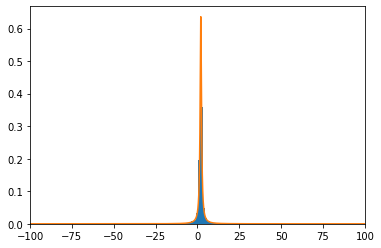

In [74]:
x_plus_y_samp = x.sample(3000) + y.sample(3000)

xs=tf.linspace(-100., 100., 10000)

plt.hist(x_plus_y_samp, bins=1000, density=True)
plt.plot(xs, z.prob(xs))
plt.xlim([-100, 100])
plt.show()

In [72]:
x_val = 1.

z_samp = z.sample(1000)

l = mu + gamma / (gamma + delta) * (z_samp - m)
s = np.sqrt(gamma * delta) / (gamma + delta)

guess = tfd.Cauchy(loc=l, scale=s.astype(np.float32))

print(x.prob(x_val))
print(tf.reduce_mean(guess.prob(x_val)))

tf.Tensor(1.5915495, shape=(), dtype=float32)
tf.Tensor(0.4657952, shape=(), dtype=float32)


In [128]:
mu = -3
nu = 3

gamma = 1.
delta = 10.

m = mu + nu
s = 1.5

x = tfd.Cauchy(loc=mu, scale=gamma)
y = tfd.Cauchy(loc=nu, scale=delta)

z = tfd.Cauchy(loc=m, scale=s)

## ==================

x_val = tf.linspace(-100., 100, 1000)

z_samp = z.sample(10000)

A = (gamma * (1 - (gamma / s)**(3. *np.sign(s - gamma)))).astype(np.float32)
B = (gamma - A) / s
C = mu - B * m

print(f"A: {A}")
print(f"B: {B}")
print(f"C: {C}")
print()
g = tfd.Cauchy(loc=B * z_samp + C, scale=A)


actual_probs = x.prob(x_val).numpy()
mc_probs = tf.reduce_mean(g.prob(x_val[:, None]), axis=1).numpy()

print(actual_probs[:10])
print(mc_probs[:10])
tf.reduce_max(tf.abs(actual_probs - mc_probs))

A: 0.7037037014961243
B: 0.1975308656692505
C: -3.0

[3.3826767e-05 3.3966837e-05 3.4107750e-05 3.4249504e-05 3.4392244e-05
 3.4535809e-05 3.4680306e-05 3.4825669e-05 3.4971945e-05 3.5119236e-05]
[2.9078714e-05 2.8419465e-05 2.7923041e-05 2.7547845e-05 2.7264559e-05
 2.7052129e-05 2.6895121e-05 2.6782147e-05 2.6704594e-05 2.6655907e-05]


<tf.Tensor: shape=(), dtype=float32, numpy=0.0033116043>

-1.0

In [663]:
def cauchy_kl(x, y):
    return  tf.math.log(tf.math.square(x.scale + y.scale) + tf.math.squared_difference(x.loc, y.loc)) \
            - tf.math.log(4.) - tf.math.log(x.scale) - tf.math.log(y.scale) 

In [ ]:
tfp.math.log

In [665]:
cauchy_kl(x, z)


<tf.Tensor: shape=(), dtype=float32, numpy=0.12773323>

In [661]:
z_samp = z.sample(10000)
tf.reduce_mean(z.log_prob(z_samp) - x.log_prob(z_samp))

<tf.Tensor: shape=(), dtype=float32, numpy=0.12994523>

In [620]:
z.entropy()

<tf.Tensor: shape=(), dtype=float32, numpy=5.5267563>

In [632]:
t = tfd.Normal(loc=0., scale=1.)
t.entropy()

<tf.Tensor: shape=(), dtype=float32, numpy=1.4189385>

In [638]:
t_samp = t.sample(1000)
tf.reduce_mean( t.log_prob(t_samp))

<tf.Tensor: shape=(), dtype=float32, numpy=-1.4377381>

In [63]:
c = tfd.Cauchy(loc=0., scale=1.)
n = tfd.Normal(loc=2., scale=1.)

n_samps = n.sample(10000)

emp_kl = tf.reduce_mean(n.log_prob(n_samps) - c.log_prob(n_samps))

emp_kl

<tf.Tensor: shape=(), dtype=float32, numpy=1.2620302>

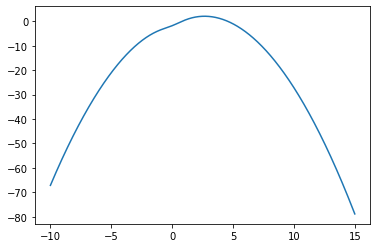

In [66]:
xs = tf.linspace(-10., 15., 1000)

plt.plot(xs, n.log_prob(xs) - c.log_prob(xs))